In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Подготовка данных

In [163]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [164]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [166]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [167]:
data['CustomerId'].nunique() == len(data)

True

**ВЫВОД:**  
1) В признаке `Tenure` есть пропуски;  
2) Признак `RowNumber` по сути копирует столбец с индексами, для решения задачи он не нужен;  
3) Признак `Surname` не нужен, так как, во-первых, есть `CustomerId`, который однозначно идентифицирует клиента, а во-вторых, от него никак не может зависеть целевая переменная;  
4) Количество уникальных значений `CustomerId` совпадает с размером выборки, значит этот признак так же для решения задачи не нужен;  
5) В данных четыре категориальных признака: `Gender`, `Geography`, `HasCrCard`, и `IsActiveMember` (первые два не закодированы); остальные количественные;  
6) Все признаки выглядят адекватно - нет отрицательных, слишком больших или слишком маленьких значений там, где их быть не должно;  
7) Наблюдается сильный дисбаланс классов.

In [168]:
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

In [169]:
try:
    data.drop(['RowNumber', 'CustomerId', 'Surname'], inplace=True, axis=1)
except:
    pass

In [170]:
data = pd.get_dummies(data, drop_first=True, columns=['Gender', 'Geography'])

In [171]:
data.sample(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
7068,699,54,3.0,111009.32,1,1,1,155905.79,1,0,1,0
7106,646,40,5.0,93680.43,2,1,1,179473.26,0,1,0,0
2369,648,54,7.0,118241.02,1,1,0,172586.89,1,0,0,1


In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Gender_Male        10000 non-null  uint8  
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Данные готовы к исследованию.

## Исследование задачи

### Дисбаланс классов

Соотношение классов:
0    0.7963
1    0.2037
Name: Exited, dtype: float64


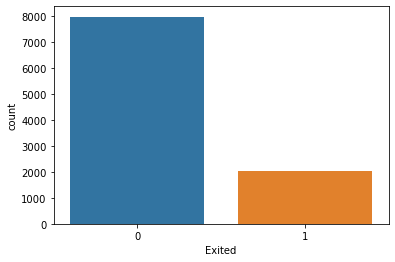

In [173]:
sns.countplot(x=data['Exited'])
print('Соотношение классов:\n',
      data['Exited'].value_counts(normalize=True),
      sep='')

In [174]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    X, y, test_size=0.4, random_state=45, stratify=y)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size=0.5,
                                                    random_state=45,
                                                    stratify=y_valid_test)
print('Признаки:')
print(f'Train size: {X_train.shape[0]}, valid size: {X_valid.shape[0]}, test size: {X_test.shape[0]}')
print('Ответы:')
print(f'Train size: {y_train.shape[0]}, valid size: {y_valid.shape[0]}, test size: {y_test.shape[0]}')

Признаки:
Train size: 6000, valid size: 2000, test size: 2000
Ответы:
Train size: 6000, valid size: 2000, test size: 2000


### Прогноз без предварительной подготовки данных

In [175]:
def calculate_metrics(y, predictions):
    metrics = pd.DataFrame(precision_recall_fscore_support(y,
                                                           predictions,
                                                           zero_division=0),
                           index=['precision', 'recall', 'f_score', 'support'])
    return metrics

In [176]:
def plot_roc_auc(y, pred):
    fpr, tpr, _ = roc_curve(y, pred)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label='ROC-AUC = %0.4f' % roc_auc_score(y, pred),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC кривая")
    plt.legend(loc="lower right")
    plt.show()

In [177]:
lr = LogisticRegression(random_state=45, n_jobs=-1)
rf = RandomForestClassifier(random_state=45, n_jobs=-1)
svm = SVC(probability=True, random_state=45)

Проверим на немасштабированных признаках, не обращая внимания на дисбаланс классов.

#### Логистическая регрессия

                     0           1
precision     0.801649    0.372881
recall        0.976773    0.054054
f_score       0.880589    0.094421
support    1593.000000  407.000000


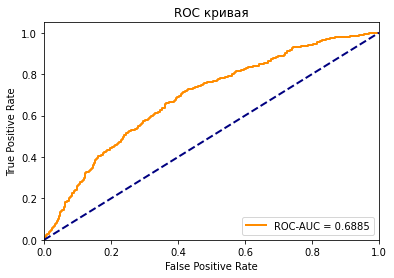

In [178]:
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_valid)

print(calculate_metrics(y_valid, lr_predictions))
plot_roc_auc(y_valid, lr.predict_proba(X_valid)[:, 1])

#### Случайный лес

                     0           1
precision     0.882867    0.725352
recall        0.951036    0.506143
f_score       0.915684    0.596237
support    1593.000000  407.000000


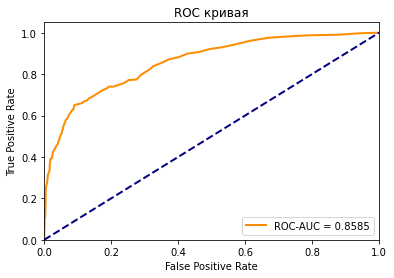

In [181]:
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_valid)

print(calculate_metrics(y_valid, rf_predictions))
plot_roc_auc(y_valid, rf.predict_proba(X_valid)[:, 1])

#### Метод опорных векторов

                     0      1
precision     0.796500    0.0
recall        1.000000    0.0
f_score       0.886724    0.0
support    1593.000000  407.0


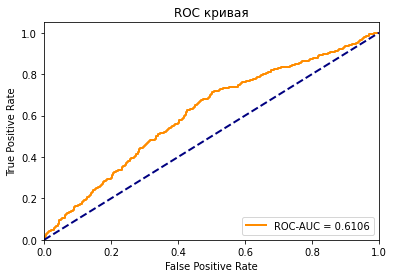

In [182]:
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_valid)

print(calculate_metrics(y_valid, svm_predictions))
plot_roc_auc(y_valid, svm.predict_proba(X_valid)[:, 1])

**ВЫВОД:**
Случайный лес показал наилучшие метрики на не подготовленных данных.
Линейная модель показала результат не на много лучше случайного прогноза.
Метод опорных векторов вообще не отличил классы друг от друга.

### Предварительная обработка

In [183]:
scaler = StandardScaler()

In [184]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Прогноз на обработанных данных

#### Логистическая регрессия

                     0           1
precision     0.826486    0.573333
recall        0.959824    0.211302
f_score       0.888179    0.308797
support    1593.000000  407.000000


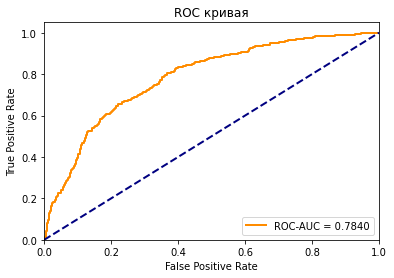

In [185]:
lr.fit(X_train_scaled, y_train)
lr_predictions_scaled = lr.predict(X_valid_scaled)

print(calculate_metrics(y_valid, lr_predictions_scaled))
plot_roc_auc(y_valid, lr.predict_proba(X_valid_scaled)[:, 1])

#### Случайны лес

                     0           1
precision     0.882867    0.725352
recall        0.951036    0.506143
f_score       0.915684    0.596237
support    1593.000000  407.000000


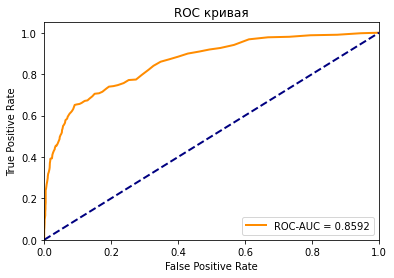

In [186]:
rf.fit(X_train_scaled, y_train)
rf_predictions_scaled = rf.predict(X_valid_scaled)

print(calculate_metrics(y_valid, rf_predictions_scaled))
plot_roc_auc(y_valid, rf.predict_proba(X_valid_scaled)[:, 1])

#### Метод опорных векторов

                     0           1
precision     0.868287    0.753247
recall        0.964218    0.427518
f_score       0.913742    0.545455
support    1593.000000  407.000000


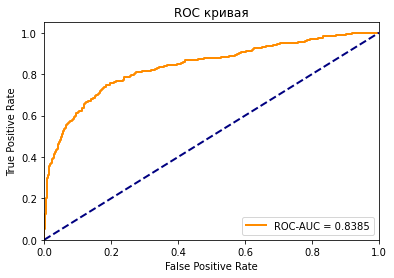

In [187]:
svm.fit(X_train_scaled, y_train)
svm_predictions_scaled = svm.predict(X_valid_scaled)

print(calculate_metrics(y_valid, svm_predictions_scaled))
plot_roc_auc(y_valid, svm.predict_proba(X_valid_scaled)[:, 1])

**ВЫВОД:**
На подготовленных данных случайный лес по прежнему показывает наилучшие результаты.
Масштабирование признаков увеличило метрики для линейной модели.
Результат работы метода опорных векторов по значениям метрик сравним со случайным лесом.

В данных классы не сбалансированы, что негативно влияет на результат. Далее постараемся побороться с дисбалансом классов и оценим моделию.

## Борьба с дисбалансом

### Upsampling

На практике метод upsampling реализуется при помощи указания параметра `class_weight='balanced'`, потому что в этом случае модель при обучении умножает потери на объекте меньшего класса на коэффициент несбалансированности классов, что равносильно повторному обучению на этом же объекте, что по сути является результатом метода upsampling.

In [188]:
lr_balanced = LogisticRegression(class_weight='balanced',
                                 random_state=45,
                                 n_jobs=-1)

rf_balanced = RandomForestClassifier(class_weight='balanced',
                                     random_state=45,
                                     n_jobs=-1)

svm_balanced = SVC(probability=True, class_weight='balanced', random_state=45)

#### Логистическая регрессия

                     0           1
precision     0.906977    0.386454
recall        0.709981    0.714988
f_score       0.796479    0.501724
support    1593.000000  407.000000


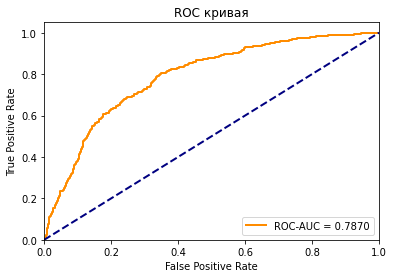

In [189]:
lr_balanced.fit(X_train_scaled, y_train)
lr_balanced_predictions = lr_balanced.predict(X_valid_scaled)

print(calculate_metrics(y_valid, lr_balanced_predictions))
plot_roc_auc(y_valid, lr_balanced.predict_proba(X_valid_scaled)[:, 1])

#### Случайный лес

                     0           1
precision     0.880787    0.738971
recall        0.955430    0.493857
f_score       0.916591    0.592047
support    1593.000000  407.000000


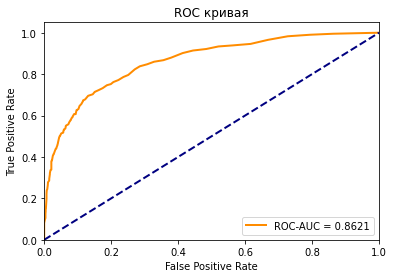

In [190]:
rf_balanced.fit(X_train, y_train)
rf_balanced_predictions = rf_balanced.predict(X_valid)

print(calculate_metrics(y_valid, rf_balanced_predictions))
plot_roc_auc(y_valid, rf_balanced.predict_proba(X_valid)[:, 1])

#### Метод опорных векторов

                     0           1
precision     0.926513    0.498366
recall        0.807282    0.749386
f_score       0.862798    0.598626
support    1593.000000  407.000000


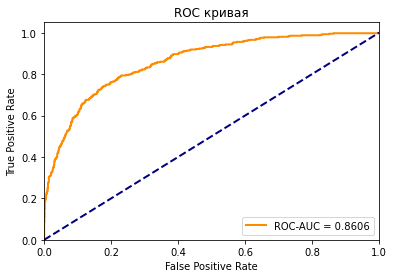

In [191]:
svm_balanced.fit(X_train_scaled, y_train)
svm_balanced_predictions = svm_balanced.predict(X_valid_scaled)

print(calculate_metrics(y_valid, svm_balanced_predictions))
plot_roc_auc(y_valid, svm_balanced.predict_proba(X_valid_scaled)[:, 1])

**ВЫВОД:**
Метрики линейной модели и метода опорных векторов значительно выросли.

### Threshold

Будем предсказывать вероятность класса и регулировать конечный результат отсечкой.

In [192]:
def tune_threshold(predictions_proba):
    threshold_best = 0
    f1_best = 0
    for threshold in np.arange(0.1, 0.91, 0.1):
        threshold_predictions_i = (predictions_proba > threshold).astype(int)
        res = f1_score(y_valid, threshold_predictions_i)
        if res > f1_best:
            f1_best = res
            threshold_best = threshold
            threshold_predictions = threshold_predictions_i
    print(f'Лучший порог: {threshold_best}\nЛучшая f1-мера: {f1_best}')
    return threshold_predictions

In [193]:
lr_threshold = LogisticRegression(random_state=45, n_jobs=-1)
rf_threshold = RandomForestClassifier(random_state=45, n_jobs=-1)
svm_threshold = SVC(random_state=45, probability=True)

In [194]:
lr_threshold.fit(X_train_scaled, y_train)
rf_threshold.fit(X_train, y_train)
svm_threshold.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=45)

In [195]:
lr_threshold_predictions_proba = lr_threshold.predict_proba(X_valid_scaled)[:, 1]
rf_threshold_predictions_proba = rf_threshold.predict_proba(X_valid)[:, 1]
svm_threshold_predictions_proba = svm_threshold.predict_proba(X_valid_scaled)[:, 1]

#### Логистическая регрессия

Лучший порог: 0.30000000000000004
Лучшая f1-мера: 0.5115740740740742

                     0           1
precision     0.879456    0.483589
recall        0.851852    0.542998
f_score       0.865434    0.511574
support    1593.000000  407.000000


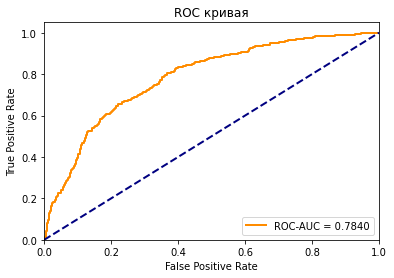

In [196]:
lr_threshold_predictions = tune_threshold(lr_threshold_predictions_proba)
print()
print(calculate_metrics(y_valid, lr_threshold_predictions))
plot_roc_auc(y_valid, lr_threshold_predictions_proba)

#### Случайный лес

Лучший порог: 0.4
Лучшая f1-мера: 0.6352941176470588

                     0           1
precision     0.900122    0.678771
recall        0.927809    0.597052
f_score       0.913756    0.635294
support    1593.000000  407.000000


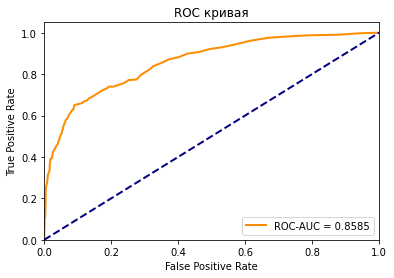

In [197]:
rf_threshold_predictions = tune_threshold(rf_threshold_predictions_proba)
print()
print(calculate_metrics(y_valid, rf_threshold_predictions))
plot_roc_auc(y_valid, rf_threshold_predictions_proba)

#### Метод опорных векторов

Лучший порог: 0.2
Лучшая f1-мера: 0.6125714285714284

                     0           1
precision     0.909269    0.572650
recall        0.874451    0.658477
f_score       0.891520    0.612571
support    1593.000000  407.000000


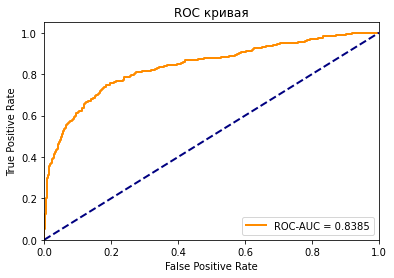

In [199]:
svm_threshold_predictions = tune_threshold(svm_threshold_predictions_proba)
print()
print(calculate_metrics(y_valid, svm_threshold_predictions))
plot_roc_auc(y_valid, svm_threshold_predictions_proba)

### SMOTE

Попробуем побороться с дисбалансом при помощи генерации синтетических данных алгоритмом SMOTE.

In [200]:
smote = SMOTE(random_state=45, n_jobs=-1)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(random_state=45, n_jobs=-1)
rf_smote = RandomForestClassifier(random_state=45, n_jobs=-1)
svm_smote = SVC(random_state=45, probability=True)

#### Логистическая регрессия

                     0           1
precision     0.907482    0.385733
recall        0.708098    0.717445
f_score       0.795487    0.501718
support    1593.000000  407.000000


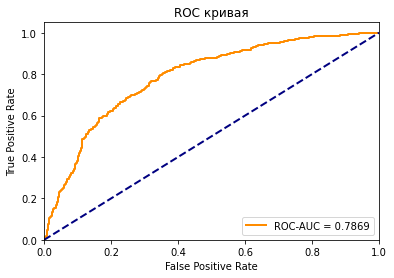

In [201]:
lr_smote.fit(X_train_smote, y_train_smote)
lr_smote_predictions = lr_smote.predict(X_valid_scaled)

print(calculate_metrics(y_valid, lr_smote_predictions))
plot_roc_auc(y_valid, lr_smote.predict_proba(X_valid_scaled)[:, 1])

#### Случайный лес

                     0           1
precision     0.903919    0.610048
recall        0.897677    0.626536
f_score       0.900787    0.618182
support    1593.000000  407.000000


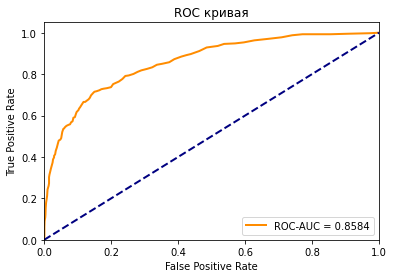

In [202]:
rf_smote.fit(X_train_smote, y_train_smote)
rf_smote_predictions = rf_smote.predict(X_valid_scaled)

print(calculate_metrics(y_valid, rf_smote_predictions))
plot_roc_auc(y_valid, rf_smote.predict_proba(X_valid_scaled)[:, 1])

#### Метод опорных векторов

                     0           1
precision     0.922967    0.500000
recall        0.812304    0.734644
f_score       0.864107    0.595025
support    1593.000000  407.000000


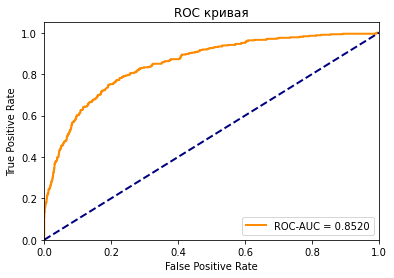

In [203]:
svm_smote.fit(X_train_smote, y_train_smote)
svm_smote_predictions = svm_smote.predict(X_valid_scaled)

print(calculate_metrics(y_valid, svm_smote_predictions))
plot_roc_auc(y_valid, svm_smote.predict_proba(X_valid_scaled)[:, 1])

## Выбор модели

По условию задания необходимо построить модель с наибольшим значением F1-меры.  
Проследим f1-меру для каждой модели и каждой стратегии, после чего выберем лучшую.

In [205]:
print('ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ')
print()
print('Без масштабирования, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, lr_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, lr_predictions_scaled).loc['f_score',: ].T)
print()
print('Масштабированные признаки, upsampling')
print('f1_мера:')
print(calculate_metrics(y_valid, lr_balanced_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, threshold')
print('f1_мера:')
print(calculate_metrics(y_valid, lr_threshold_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, SMOTE')
print('f1_мера:')
print(calculate_metrics(y_valid, lr_smote_predictions).loc['f_score',: ].T)

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Без масштабирования, без учета дисбаланса классов
f1_мера:
0    0.880589
1    0.094421
Name: f_score, dtype: float64

Масштабированные признаки, без учета дисбаланса классов
f1_мера:
0    0.888179
1    0.308797
Name: f_score, dtype: float64

Масштабированные признаки, upsampling
f1_мера:
0    0.796479
1    0.501724
Name: f_score, dtype: float64

Масштабированные признаки, threshold
f1_мера:
0    0.865434
1    0.511574
Name: f_score, dtype: float64

Масштабированные признаки, SMOTE
f1_мера:
0    0.795487
1    0.501718
Name: f_score, dtype: float64


**ВЫВОД:**  
Ни одна стратегия для модели логистической регрессии не показала требуемый результат. Эта модель не подходит для данной задачи.

In [206]:
print('СЛУЧАЙНЫЙ ЛЕС')
print()
print('Без масштабирования, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, rf_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, rf_predictions_scaled).loc['f_score',: ].T)
print()
print('Масштабированные признаки, upsampling')
print('f1_мера:')
print(calculate_metrics(y_valid, rf_balanced_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, threshold')
print('f1_мера:')
print(calculate_metrics(y_valid, rf_threshold_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, SMOTE')
print('f1_мера:')
print(calculate_metrics(y_valid, rf_smote_predictions).loc['f_score',: ].T)

СЛУЧАЙНЫЙ ЛЕС

Без масштабирования, без учета дисбаланса классов
f1_мера:
0    0.915684
1    0.596237
Name: f_score, dtype: float64

Масштабированные признаки, без учета дисбаланса классов
f1_мера:
0    0.915684
1    0.596237
Name: f_score, dtype: float64

Масштабированные признаки, upsampling
f1_мера:
0    0.916591
1    0.592047
Name: f_score, dtype: float64

Масштабированные признаки, threshold
f1_мера:
0    0.913756
1    0.635294
Name: f_score, dtype: float64

Масштабированные признаки, SMOTE
f1_мера:
0    0.900787
1    0.618182
Name: f_score, dtype: float64


**ВЫВОД:**  
Все стратегии обучения случайного леса показали результат выше требуемого f1-score == 0.59. При настройке порога отсечки результаты наилучшие. Выбираем эту стратегию для финальной настройки.

In [207]:
print('МЕТОД ОПОРНЫХ ВЕКТОРОВ')
print()
print('Без масштабирования, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, svm_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, без учета дисбаланса классов')
print('f1_мера:')
print(calculate_metrics(y_valid, svm_predictions_scaled).loc['f_score',: ].T)
print()
print('Масштабированные признаки, upsampling')
print('f1_мера:')
print(calculate_metrics(y_valid, svm_balanced_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, threshold')
print('f1_мера:')
print(calculate_metrics(y_valid, svm_threshold_predictions).loc['f_score',: ].T)
print()
print('Масштабированные признаки, SMOTE')
print('f1_мера:')
print(calculate_metrics(y_valid, svm_smote_predictions).loc['f_score',: ].T)

МЕТОД ОПОРНЫХ ВЕКТОРОВ

Без масштабирования, без учета дисбаланса классов
f1_мера:
0    0.886724
1    0.000000
Name: f_score, dtype: float64

Масштабированные признаки, без учета дисбаланса классов
f1_мера:
0    0.913742
1    0.545455
Name: f_score, dtype: float64

Масштабированные признаки, upsampling
f1_мера:
0    0.862798
1    0.598626
Name: f_score, dtype: float64

Масштабированные признаки, threshold
f1_мера:
0    0.891520
1    0.612571
Name: f_score, dtype: float64

Масштабированные признаки, SMOTE
f1_мера:
0    0.864107
1    0.595025
Name: f_score, dtype: float64


**ВЫВОД:**  
Для получения проходного результата на модели SVM необходимо как отмастабировать признаки, так и учесть дисбаланс классов. Наивысшее значение f1-меры достигается при настройке порога отсечки. Эта стратегия будет использована при фаинальной настройке.

## Настройка гиперпараметров

In [209]:
cv = StratifiedKFold(shuffle=True, random_state=45)

### Случайный лес

#### SMOTE

#### Threshold

In [232]:
# rf_final = RandomForestClassifier(n_jobs=-1, random_state=45, warm_start=True)
# params = {
#     'n_estimators': [n for n in range(100, 501, 100)],
#     'max_depth': [8, 10, 12, None],
#     'max_features': [6, 9, 'sqrt', None]
# }

In [233]:
# %%time
# rf_cv = GridSearchCV(rf_final,
#                           param_grid=params,
#                           scoring='f1',
#                           n_jobs=-1,
#                           cv=cv,
#                           verbose=True)
# rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Wall time: 1min 16s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=45,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13], 'max_features': [5, 6, 7],
                         'n_estimators': [190, 200, 210]},
             scoring='f1', verbose=True)

Лучшие параметры на `GridSearch`: `n_estimators` = 200, `max_depth` = 12, `max_features` = 6.  
Лучшая F1-мера на кросс валидации: 0.599329817224954  

In [243]:
rf_final_tuned_threshold = RandomForestClassifier(n_estimators=200,
                                                  max_depth=12,
                                                  max_features=6,
                                                  n_jobs=-1,
                                                  random_state=45)
rf_final_tuned_threshold.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features=6, n_estimators=200,
                       n_jobs=-1, random_state=45)

Лучший порог: 0.4
Лучшая f1-мера: 0.62532981530343
                     0           1
precision     0.896907    0.675214
recall        0.928437    0.582310
f_score       0.912400    0.625330
support    1593.000000  407.000000


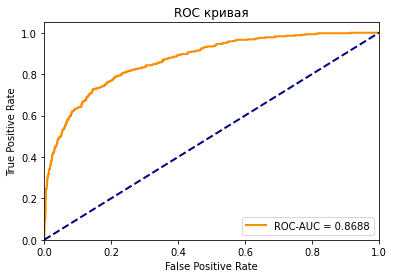

In [244]:
rf_final_predictions_proba = rf_final_tuned_threshold.predict_proba(X_valid)[:, 1]
rf_final_predictions_threshold = tune_threshold(rf_final_predictions_proba)
print(calculate_metrics(y_valid, rf_final_predictions_threshold))
plot_roc_auc(y_valid, rf_final_predictions_proba)

Без настройки гиперпараметров
                     0           1
precision     0.900122    0.678771
recall        0.927809    0.597052
f_score       0.913756    0.635294
support    1593.000000  407.000000


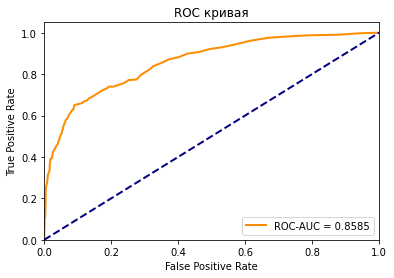

In [236]:
print('Без настройки гиперпараметров')
print(calculate_metrics(y_valid, rf_threshold_predictions))
plot_roc_auc(y_valid, rf_threshold_predictions_proba)

### Метод опорных векторов

#### Thershold

In [247]:
# svm_final = SVC(probability=True, random_state=45)
# params = {
#     'C': np.logspace(-2, 3, 6, endpoint=True),
#     'gamma': ['scale', 'auto']
# }

# svm_cv = GridSearchCV(svm_final,
#                       param_grid=params,
#                       scoring='f1',
#                       n_jobs=-1,
#                       cv=cv,
#                       verbose=True)

In [248]:
# %%time
# svm_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Wall time: 3min 43s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=45, shuffle=True),
             estimator=SVC(probability=True, random_state=45), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': ['scale', 'auto']},
             scoring='f1', verbose=True)

Лучшие параметры на `GridSearch`: `C` = 10, `gamma` = 'scale'.  
Лучшая F1-мера на кросс валидации: 0.5577516904514563 

In [254]:
svm_final_tuned_threshold = SVC(C=10, gamma='scale', probability=True, random_state=45)
svm_final_tuned_threshold.fit(X_train_scaled, y_train)

SVC(C=10, probability=True, random_state=45)

Лучший порог: 0.30000000000000004
Лучшая f1-мера: 0.5994962216624685
                     0           1
precision     0.895226    0.614987
recall        0.906466    0.584767
f_score       0.900811    0.599496
support    1593.000000  407.000000


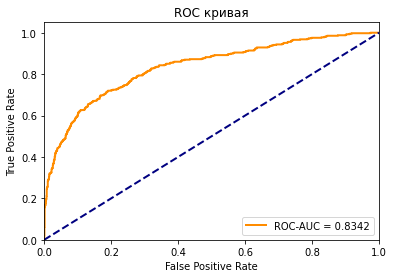

In [255]:
svm_final_predictions_proba = svm_final_tuned_threshold.predict_proba(X_valid_scaled)[:, 1]
svm_final_predictions_threshold = tune_threshold(svm_final_predictions_proba)
print(calculate_metrics(y_valid, svm_final_predictions_threshold))
plot_roc_auc(y_valid, svm_final_predictions_proba)

Без настройки гиперпараметров
                     0           1
precision     0.909269    0.572650
recall        0.874451    0.658477
f_score       0.891520    0.612571
support    1593.000000  407.000000


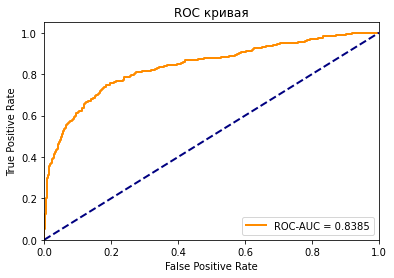

In [256]:
print('Без настройки гиперпараметров')
print(calculate_metrics(y_valid, svm_threshold_predictions))
plot_roc_auc(y_valid, svm_threshold_predictions_proba)

## Тестирование модели

In [267]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

f1-score= 0.5855728429985856


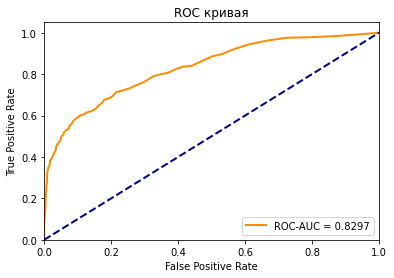

In [274]:
model = RandomForestClassifier(random_state=45, n_jobs=-1)
model.fit(X, y)
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = (predictions_proba > 0.4).astype(int)
print('f1-score =',f1_score(y_test, predictions))
plot_roc_auc(y_test, predictions_proba)

f1-score= 0.5910364145658263


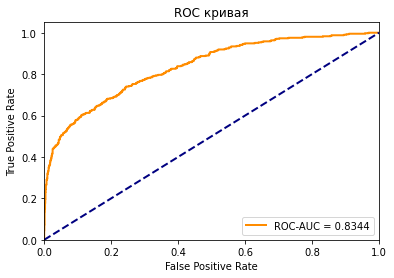

In [275]:
model = RandomForestClassifier(n_estimators=200,
                               max_depth=12,
                               max_features=6,
                               n_jobs=-1,
                               random_state=45)
model.fit(X, y)
predictions_proba = model.predict_proba(X_test)[:, 1]
predictions = (predictions_proba > 0.4).astype(int)
print('f1-score =',f1_score(y_test, predictions))
plot_roc_auc(y_test, predictions_proba)

## Общий вывод

А пока ты, мой любимый ревьюер, ждешь, когда дотюнится мой SVM, почитай общий вывод по проекту :)  
  
На основе проделанной работы я рекомендую в качестве финальной модели "Бета-Банку" выбрать случайный лес, а с дисбалансом классов бороться при помощи алгоритма SMOTE. Для дальнейшего улучшения качества классификации нужно попробовать другие модели, в частности нейронные сети. Также будет полезно применить немного feature engineering.  
  
Я, честно говоря, не понимаю почему настройка гиперпараметров SVM ведет к ухудшению качества модели. Было бы здорово, если бы ты мне объяснил. Заранее благодарен.  
Самое загадочное, что параметры "по умолчанию" были в сетке, модель через них проходила и на кросс-валидации не выбрала их как лучшие, а при проверке на холд ауте выдала плохой результат.  
Также я заметил, что на кросс-валидации ROC-AUC у меня намного выше, чем на тесте. Это значит, что модель переобучилась. Почему? Как это исправить?  
  
**UPD:**  
На тесте настроенная модель все-таки показала себя лучше.  
Результатами я не доволен, не смотря на то, что получил целевую метрику больше требуемого порога.  
Подскажи пожалуйста, как улучшить решение? На kaggle на этом датасете получают f1-меру 0.8. Хочется получить примерно такой же результат.  
Да, там используется NN. Методами классического ML такое значение метрики не получить?

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*